<a href="https://colab.research.google.com/github/ducndh/cs320MachineLearningProjects/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
#force_remount = True means that if you run this cell again, it will re-load your
#drive. That's necessary because otherwise, if you make changes to files in Drive,
#you won't see them in Colab - you have to re-run this cell to load the changes.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Check if accessing correctly
!ls drive/Shared\ drives/ML_Final_Project

'Copy of FinalProject.ipynb'
 data
 FinalProject.ipynb
'Final Project Presentation: Duc and Tonyn .gslides'
'Final Project Report.gdoc'
'Project Milestone - Duc and Tony .gdoc'


In [ ]:
!head drive/Shared\ drives/ML_Final_Project/data/results.csv

date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2
2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2
2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2
2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2
2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2
2020-03-17,Singularity,Endpoint,Overpass,13,16,2,2,8,6,5,10,5247,2340456,71,41,0,2,2
2020-03-17,Singularity,Endpoint,Vertigo,11,16,2,1,6,9,5,7,5247,2340456,71,41,0,2,2
2020-03-17,Espada,Tricked,Dust2,16,10,1,2,3,8,13,2,5247,2340455,56,77,2,0,1
2020-03-17,Espada,Tricked,Nuke,16,10,1,1,7,8,9,2,5247,2340455,56,77,2,0,1


In [ ]:
# Loading data
# Modify this cell to import pandas and load the data of 4 different starter files in
import pandas as pd
df_map = pd.read_csv('drive/Shared drives/ML_Final_Project/data/results.csv')
df_pick = pd.read_csv('drive/Shared drives/ML_Final_Project/data/picks.csv')
df_player = pd.read_csv('drive/Shared drives/ML_Final_Project/data/players.csv')
df_econ = pd.read_csv('drive/Shared drives/ML_Final_Project/data/economy.csv')

# Merging pick and main dataframe
df_pick['team_3'] = df_pick['team_1']
df_pick['team_4'] = df_pick['team_2']
df_pick.loc[df_pick['inverted_teams'] == 1, 'team_1'] = df_pick['team_4']
df_pick.loc[df_pick['inverted_teams'] == 1, 'team_2'] = df_pick['team_3']

df_pick['team_3'] = df_pick['t1_picked_1']
df_pick['team_4'] = df_pick['t2_picked_1']
df_pick.loc[df_pick['inverted_teams'] == 1, 't1_picked_1'] = df_pick['team_4']
df_pick.loc[df_pick['inverted_teams'] == 1, 't2_picked_1'] = df_pick['team_3']

df_pick = df_pick[['match_id', 't1_picked_1', 't2_picked_1', 'left_over']]
df_map = df_map.merge(df_pick, on='match_id', how='left')
df_map.loc[df_map['_map'] == df_map['t1_picked_1'], 'pick'] = 1
df_map.loc[df_map['_map'] == df_map['t2_picked_1'], 'pick'] = -1
df_map.loc[df_map['_map'] == df_map['left_over'], 'pick'] = 0
df_map.loc[df_map['starting_ct'] == 2, 'starting_ct'] = -1

# Sort out all the unnecessary data points
df_map = df_map.loc[(df_map['team_1'] != 'undefined') & (df_map['team_2'] != 'undefined')]
df_map = df_map.loc[(df_map['rank_1']<= 200) & (df_map['rank_2']<= 200)].reset_index(drop=True)

# One hot encoding the map and create result differences
df = df_map
df['_map'] = df['_map'].astype('category').cat.codes
df['result'] = df['result_1'] - df['result_2']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Create the dictionary to faster finding the data points
team_dict = {}
player_dict = {}
for index, row in df.iterrows():
    team_1 = row['team_1']
    team_2 = row['team_2']
    if not team_1 in team_dict:
      team_dict[team_1] = df.loc[(df['team_1'] == team_1) | (df['team_2'] == team_1)].sort_values('date', ascending=False)
    if not team_2 in team_dict:
      team_dict[team_2] = df.loc[(df['team_2'] == team_2) | (df['team_2'] == team_2)].sort_values('date', ascending=False)
    if not team_1 in player_dict:
      player_dict[team_1] = df_player.loc[(df_player['team'] == team_1)]
    if not team_2 in player_dict:
      player_dict[team_2] = df_player.loc[(df_player['team'] == team_2)]

In [ ]:
# Looking for match history of every matches and create new features
for i in range(15):
  for j in ['1','2']:
    string = 'team' + j + '_map' + str(i)
    string_result = string + '_result'
    string_rank = string + '_rank_diff'
    df[string_result] = None
    df[string_rank] = None
    
for i in range(5):
  for j in ['1','2']:
    string = 'team' + j + '_match' + str(i)
    string_result = string + '_result'
    string_rank = string + '_rank_diff'
    df[string_result] = None
    df[string_rank] = None
    
for index, row in df.iterrows():
  print(index)
  for i in ['1' , '2']:
    team = 'team_' + i
    df_team = team_dict[row[team]]
    df_team = df_team.loc[df_team['date'] < row['date']].reset_index(drop=True)
    df_map_team = df_team
    df_map_team = df_map_team[:15]
    df_match_team = df_team
    df_match_team = df_match_team.loc[df_match_team['_map'] == row['_map']][:5].reset_index(drop=True)

    for index_team, row_team in df_map_team.iterrows():
      string = 'team' + i + '_map' + str(index_team)
      string_result = string + '_result'
      string_rank = string + '_rank_diff'
      if row[team] == row_team['team_1']:
        df.loc[index, string_result] = row_team['result']
        df.loc[index, string_rank] = row_team['rank_1'] - row_team['rank_2']
      elif row[team] == row_team['team_2']:
        df.loc[index, string_result] = (-1)*row_team['result']
        df.loc[index, string_rank] = row_team['rank_2'] - row_team['rank_1']

    for index_team, row_team in df_match_team.iterrows():
      string = 'team' + i + '_match' + str(index_team)
      string_result = string + '_result'
      string_rank = string + '_rank_diff'
      if row[team] == row_team['team_1']:
        df.loc[index, string_result] = row_team['result']
        df.loc[index, string_rank] = row_team['rank_1'] - row_team['rank_2']
      elif row[team] == row_team['team_2']:
        df.loc[index, string_result] = (-1)*row_team['result']
        df.loc[index, string_rank] = row_team['rank_2'] - row_team['rank_1']
df.to_csv(r'configure_data.csv')
df

In [ ]:
# Looking for head to head matches
for i in range(5):
    string = 'h2h_match' + str(i)
    string_result = string + '_result'
    df[string_result] = None

for index, row in df.iterrows():
  print(index)
  df_h2h = team_dict[row['team_1']]
  df_h2h = df_h2h.loc[(((df_h2h['team_1'] == row['team_2']) & (df_h2h['team_2'] == row['team_1'])) |
                       ((df_h2h['team_1'] == row['team_1']) & (df_h2h['team_2'] == row['team_2']))) &
                        (df_h2h['date'] < row['date'])].sort_values('date')[:5].reset_index(drop=True)
  for i, r in df_h2h.iterrows():
    string = 'h2h_match' + str(i)
    string_result = string + '_result'
    if df.loc[index, 'team_1'] == r['team_1']:
      df.loc[index, string_result] = r['result']
    elif df.loc[index, 'team_1'] == r['team_2']:
      df.loc[index, string_result] = r['result']*(-1)
df.to_csv(r'configure_data_h2h.csv')
df

In [ ]:
# Looking for player rating in another file
for i in range(5):
  for j in ['1', '2']:
    string = 'player' + str(i) + '_team' + j
    for k in range(15):
      string_rating = string + '_map' + str(k) + '_rating'
      df[string_rating] = None

for index, row in df.iterrows():
  print(index)
  for i in ['1', '2']:
    string_team = 'team_' + i
    team = row[string_team]
    df_player_team = player_dict[team]
    df_player_team = df_player_team.loc[df_player_team['date'] <= row['date']].reset_index(drop=True)
    current_team = df_player_team[:5]
    df_player_team = df_player_team.loc[df_player_team['date'] < row['date']][:75].reset_index(drop=True)
    if (not df_player_team.empty):
      for index_player, row_player in current_team.iterrows():
        player = row_player['player_id']
        df_player = df_player_team.loc[df_player_team['player_id'] == player].reset_index(drop=True)
        string = 'player' + str(index_player) + '_team' + i
        for index_match, row_match in df_player.iterrows():
          string_rating = string + '_map' + str(index_match) +'_rating'
          df.loc[index, string_rating] = row_match['rating']
df.to_csv(r'configure_data_player.csv')
df

In [ ]:
# Read the fully combined file and pick features to look at

import pandas as pd
import numpy as np
from sklearn import preprocessing

df = pd.read_csv('drive/Shared drives/ML_Final_Project/data/configure_data_full.csv')
test_list = pd.read_csv('drive/Shared drives/ML_Final_Project/data/test_list.csv')['match_id'].to_list()
df.loc[:, ['t1_picked_1', 't2_picked_1', 'left_over', 'pick']] = df[['t1_picked_1', 't2_picked_1', 'left_over', 'pick']].fillna(0)
df = df.dropna(subset=['team1_map4_result',
  'team2_map4_result', 'team1_match2_result',
  'team2_match2_result', 'h2h_match2_result',
 'player0_team1_map2_rating', 'player1_team1_map2_rating',
 'player2_team1_map2_rating', 'player3_team1_map2_rating',
 'player4_team1_map2_rating', 'player0_team2_map2_rating', 
 'player1_team2_map2_rating', 'player2_team2_map2_rating',
 'player3_team2_map2_rating', 'player4_team2_map2_rating'])

# df = df.dropna(subset=['team1_map14_result',
#   'team2_map14_result', 'team1_match4_result',
#   'team2_match4_result', 'h2h_match4_result'])

df = df.drop(df.columns[[0, 1, 2]],axis=1)
df = df.dropna(axis=1).reset_index(drop=True)
df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner,t1_picked_1,t2_picked_1,left_over,pick,result,ct_diff,t_diff,team1_map0_result,team1_map0_rank_diff,team2_map0_result,team2_map0_rank_diff,team1_map1_result,team1_map1_rank_diff,team2_map1_result,team2_map1_rank_diff,team1_map2_result,team1_map2_rank_diff,team2_map2_result,team2_map2_rank_diff,team1_map3_result,team1_map3_rank_diff,...,team2_match0_rank_diff,team1_match1_result,team1_match1_rank_diff,team2_match1_result,team2_match1_rank_diff,team1_match2_result,team1_match2_rank_diff,team2_match2_result,team2_match2_rank_diff,h2h_match0_result,player0_team1_map0_rating,player1_team1_map0_rating,player2_team1_map0_rating,player3_team1_map0_rating,player4_team1_map0_rating,player0_team1_map1_rating,player1_team1_map1_rating,player2_team1_map1_rating,player3_team1_map1_rating,player4_team1_map1_rating,player0_team1_map2_rating,player1_team1_map2_rating,player2_team1_map2_rating,player3_team1_map2_rating,player4_team1_map2_rating,player0_team2_map0_rating,player1_team2_map0_rating,player2_team2_map0_rating,player3_team2_map0_rating,player4_team2_map0_rating,player0_team2_map1_rating,player1_team2_map1_rating,player2_team2_map1_rating,player3_team2_map1_rating,player4_team2_map1_rating,player0_team2_map2_rating,player1_team2_map2_rating,player2_team2_map2_rating,player3_team2_map2_rating,player4_team2_map2_rating
0,2020-02-26,AVANT,madlikewizards,7,16,11,1,-1,7,5,9,6,5152,2339428,103,124,16,11,1,0.0,0.0,Overpass,0.0,5,2,3,15.0,50.0,13.0,-56.0,10.0,-64.0,10.0,3.0,2.0,-58.0,13.0,-75.0,7.0,-73.0,...,-22.0,-4.0,-1.0,-7.0,47.0,-9.0,47.0,-4.0,-49.0,-4.0,0.75,1.07,1.23,1.18,1.55,1.48,1.33,2.05,1.32,1.97,1.49,1.40,1.47,1.28,1.95,0.41,0.57,0.18,1.15,0.45,1.36,1.04,1.27,1.59,1.25,0.89,1.48,1.27,0.54,1.42
1,2020-02-26,G2,mousesports,3,13,16,2,-1,1,13,12,3,4901,2339384,8,2,2,1,1,Dust2,Inferno,Nuke,1.0,-3,-12,9,13.0,-2.0,2.0,-17.0,14.0,-2.0,7.0,-17.0,-11.0,-17.0,3.0,-4.0,9.0,-17.0,...,-11.0,-11.0,-17.0,-13.0,-9.0,10.0,-17.0,2.0,8.0,3.0,1.74,1.39,1.77,1.15,1.62,1.10,0.89,1.16,1.14,0.96,1.22,1.34,1.27,1.34,1.13,1.09,1.33,1.34,1.31,1.26,1.05,1.14,1.00,1.21,0.91,0.90,1.38,1.09,1.15,1.24
2,2020-02-26,Liquid,Evil Geniuses,6,15,19,2,1,11,4,4,11,4901,2339385,3,5,2,1,1,Overpass,Nuke,Inferno,-1.0,-4,7,-7,-14.0,-5.0,-2.0,-6.0,6.0,-8.0,11.0,-6.0,2.0,-8.0,9.0,-6.0,-7.0,-5.0,...,-6.0,6.0,-3.0,3.0,-5.0,-9.0,2.0,12.0,-11.0,2.0,1.23,1.12,1.04,1.21,1.00,0.70,0.68,0.83,0.91,0.77,1.14,1.18,1.05,1.34,0.94,1.48,1.11,1.34,0.93,0.91,0.87,0.93,1.10,1.03,1.01,1.33,1.25,1.23,1.11,1.33
3,2020-02-26,NiP,Natus Vincere,8,10,16,2,1,6,9,4,7,4901,2339390,12,6,0,2,2,Mirage,Train,Nuke,-1.0,-6,-3,-3,-8.0,3.0,-9.0,2.0,-9.0,3.0,2.0,2.0,9.0,3.0,-4.0,2.0,3.0,3.0,...,-36.0,5.0,7.0,-10.0,7.0,-7.0,-3.0,5.0,6.0,-3.0,1.33,1.40,1.38,1.41,1.49,0.85,1.09,0.76,1.23,0.90,0.89,0.79,1.20,1.05,0.84,0.99,0.81,0.87,0.83,1.29,1.00,1.07,1.00,0.90,1.15,1.35,0.96,0.96,1.26,1.44
4,2020-02-26,Liquid,Evil Geniuses,7,16,7,1,-1,7,1,9,6,4901,2339385,3,5,2,1,1,Overpass,Nuke,Inferno,1.0,9,6,3,-14.0,-5.0,-2.0,-6.0,6.0,-8.0,11.0,-6.0,2.0,-8.0,9.0,-6.0,-7.0,-5.0,...,1.0,-5.0,-1.0,-10.0,1.0,-3.0,-3.0,11.0,-11.0,2.0,1.23,1.12,1.04,1.21,1.00,0.70,0.68,0.83,0.91,0.77,1.14,1.18,1.05,1.34,0.94,1.48,1.11,1.34,0.93,0.91,0.87,0.93,1.10,1.03,1.01,1.33,1.25,1.23,1.11,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12731,2015-12-12,Natus Vincere,Luminosity,1,16,11,1,-1,9,3,7,8,1986,2299865,5,7,2,1,1,0,0,0,0.0,5,6,-1,-4.0,2.0,-11.0,2.0,-3.0,2.0,-4.0,2.0,11.0,-2.0,4.0,12.0,4.0,-2.0,...,9.0,-2.0,4.0,-8.0,13.0,2.0,-13.0,10.0,8.0,2.0,0.78,0.99,0.87,1.16,0.99,0.94,1.30,0.95,1.57,1.06,0.80,1.07,0.98,0.80

In [ ]:
# Calculating the stat of naively picking

strong_map_pick = len(df.loc[((df['rank_1'] > df['rank_2']) & (df['pick'] == 2) & (df['result'] < 0)) | ((df['rank_1'] < df['rank_2']) & (df['pick'] == 1) & (df['result'] > 0))])
strong_map = len(df.loc[((df['rank_1'] > df['rank_2']) & (df['pick'] == 2)) | ((df['rank_1'] < df['rank_2']) & (df['pick'] == 1))])
weak_map_pick = len(df.loc[((df['rank_1'] > df['rank_2']) & (df['pick'] == 1) & (df['result'] > 0)) | ((df['rank_1'] < df['rank_2']) & (df['pick'] == 2) & (df['result'] < 0))])
weak_map = len(df.loc[((df['rank_1'] > df['rank_2']) & (df['pick'] == 1)) | ((df['rank_1'] < df['rank_2']) & (df['pick'] == 2))])
# rank_pick = len(df.loc[((df['rank_1'] > df['rank_2']) & (df['result'] < 0)) | ((df['rank_1'] < df['rank_2']) & (df['result'] > 0))])
# total = len(df)
print('strong_win_percentage:', strong_map_pick/strong_map)
print('weak_win_percentage:', weak_map_pick/weak_map)
# print('rank_win:', rank_pick/total)

In [ ]:
# Normalize the basic features
df_result = df[['match_id', 'result']]
df_result['result'] = df_result['result']/16
# df_result = df[['match_id', 'map_winner']]
# df_result.replace(2, 0, inplace=True)

df_data = df[['pick', 'starting_ct', 'match_id']]
df_data['rank_1'] = df['rank_1']/100 - 1
df_data['rank_2'] = df['rank_2']/100 - 1
map = pd.get_dummies(df['_map'], prefix='map')
df_data = pd.concat([df_data, map], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
# Normalize match histories features

for i in ['1', '2']:
  string_map = 'team' + i + '_map'
  string_match = 'team' + i + '_match'
  for j in range(3):
    result = string_map + str(j) + '_result'
    rank = string_map + str(j) + '_rank_diff'
    df_data[result] = df[result]/16
    df_data[rank] = df[rank]/100
    if j < 2:
      for l in range(5):
        string_rating = 'player' + str(l) + '_'  + string_map + str(j) + '_rating'
        df_data[string_rating] = df[string_rating]/2 - 0.5

  for k in range(3):
    result = string_match + str(k) + '_result'
    rank = string_match + str(k) + '_rank_diff'
    df_data[result] = df[result]/16
    df_data[rank] = df[rank]/100

for i in range(1):
  string = 'h2h_match' + str(i) + '_result'
  df_data[string] = df[string]/16

In [ ]:
# To do: Combining rank and result of past matches

drop = []
for i in ['1', '2']:
  team = 'team' + i
  for j in range(15):
    df_data['sign'] = None
    df_data['power'] = None

    map = team + '_map' + str(j)
    result = map + '_result'
    rank_diff = map + '_rank_diff'
    result_scaled = result + '_scaled'

    df_data[result] = df[result]
    df_data[rank_diff] = df[rank_diff]

    df_data.loc[df_data[result] > 0, 'sign'] = -1
    df_data.loc[df_data[result] < 0, 'sign'] = 1
    df_data['power'] = (df_data['sign'] * df_data[rank_diff]/2000).astype(float)
    df_data[result_scaled] = df_data[result]/32 * np.exp(df_data['power'])
    
    drop.append(result)
    drop.append(rank_diff)

    if j < 5:
      for k in range(5):
        player = 'player' + str(k) + '_' + map + '_rating'
        df_data[player] = df[player]
        rating_scaled = player + '_scaled'
        df_data[rating_scaled] = df_data[player]/2 - 0.5
        drop.append(player)

    for j in range(5):
      df_data['sign'] = None
      df_data['power'] = None

      match = team + '_match' + str(j)
      result = match + '_result'
      rank_diff = match + '_rank_diff'
      result_scaled = result + '_scaled'

      df_data[result] = df[result]
      df_data[rank_diff] = df[rank_diff]

      df_data.loc[df_data[result] > 0, 'sign'] = -1
      df_data.loc[df_data[result] < 0, 'sign'] = 1
      df_data['power'] = (df_data['sign'] * df_data[rank_diff]/2000).astype(float)
      df_data[result_scaled] = df_data[result]/32 * np.exp(df_data['power'])

      drop.append(result)
      drop.append(rank_diff)

for i in range(5):
  string = 'h2h_match' + str(i) + '_result'
  df_data[string] = df[string]/16

drop.append('sign')
drop.append('power')
df_data = df_data.drop(columns = drop)
df_data

,pick,starting_ct,match_id,rank_1,rank_2,map_0,map_1,map_3,map_4,map_5,map_6,map_7,map_8,map_9,team1_map0_result_scaled,team1_match0_result_scaled,team1_match1_result_scaled,team1_match2_result_scaled,team1_match3_result_scaled,team1_match4_result_scaled,team1_map1_result_scaled,team1_map2_result_scaled,team1_map3_result_scaled,team1_map4_result_scaled,team1_map5_result_scaled,team1_map6_result_scaled,team1_map7_result_scaled,team1_map8_result_scaled,team1_map9_result_scaled,team1_map10_result_scaled,team1_map11_result_scaled,team1_map12_result_scaled,team1_map13_result_scaled,team1_map14_result_scaled,team2_map0_result_scaled,team2_match0_result_scaled,team2_match1_result_scaled,team2_match2_result_scaled,team2_match3_result_scaled,team2_match4_result_scaled,team2_map1_result_scaled,team2_map2_result_scaled,team2_map3_result_scaled,team2_map4_result_scaled,team2_map5_result_scaled,team2_map6_result_scaled,team2_map7_result_scaled,team2_map8_result_scaled,team2_map9_result_scaled,team2_map10_result_scaled,team2_map11_result_scaled,team2_map12_result_scaled,team2_map13_result_scaled,team2_map14_result_scaled,h2h_match0_result,h2h_match1_result,h2h_match2_result,h2h_match3_result,h2h_match4_result
0,1.0,-1,2339384,-0.92,-0.98,0,0,1,0,0,0,0,0,0,0.410333,0.441897,-0.315739,0.340224,0.094692,0.065704,0.441897,-0.315739,0.306202,0.068045,0.272179,0.340224,0.126256,0.094692,-0.053794,-0.059452,0.065704,0.098557,0.217844,0.145229,0.068045,0.099051,-0.388374,0.060049,0.354109,0.067032,0.238157,0.095644,-0.122525,-0.214418,-0.147888,0.165084,0.099051,0.376880,0.157033,0.357779,-0.388374,-0.272938,-0.140676,0.152392,0.1875,-0.3750,-0.1250,0.1875,-0.1875
1,-1.0,1,2339390,-0.88,-0.94,0,0,0,0,0,0,0,1,0,-0.253778,0.126256,0.150876,-0.215493,-0.060350,0.399381,-0.285501,0.277063,0.092354,0.126256,0.315641,0.150876,-0.129452,-0.064726,-0.384493,-0.322117,-0.087850,0.096605,-0.151632,0.257614,-0.284077,0.224478,-0.323631,0.151632,0.101558,0.101558,0.061878,-0.126256,-0.215493,0.190334,0.063445,0.261891,0.224478,0.123756,0.309391,-0.323631,0.060350,0.211226,-0.220948,-0.126256,-0.1875,-0.4375,-0.3750,0.1250,0.1250
2,-1.0,1,2339391,-0.93,-0.91,0,0,0,0,1,0,0,0,0,-0.225412,-0.155055,0.122525,-0.220948,-0.123756,0.253778,-0.096605,0.129452,0.194179,-0.123756,-0.309391,-0.155055,-0.284267,0.220948,0.126256,0.133395,0.133395,-0.095644,0.122525,0.214418,0.134736,0.202103,0.301643,0.408286,-0.243827,-0.155471,0.202103,-0.063445,-0.190334,0.215493,-0.262236,0.301643,0.368675,-0.286932,0.336943,0.214418,-0.517810,-0.453084,0.120099,-0.065051,0.5625,0.4375,-0.6250,0.8125,-0.2500
3,1.0,-1,2339391,-0.93,-0.91,0,0,0,0,0,1,0,0,0,-0.225412,0.194179,0.214418,0.410333,0.685446,0.393171,-0.096605,0.129452,0.194179,-0.123756,-0.309391,-0.155055,-0.284267,0.220948,0.126256,0.133395,0.133395,-0.095644,0.122525,0.214418,0.134736,0.215493,-0.453084,0.120099,0.207044,-0.241756,0.202103,-0.063445,-0.190334,0.215493,-0.262236,0.301643,0.368675,-0.286932,0.336943,0.214418,-0.517810,-0.453084,0.120099,-0.065051,0.5625,0.4375,-0.6250,0.8125,-0.2500
4,0.0,1,2339391,-0.93,-0.91,0,0,0,1,0,0,0,0,0,-0.225412,-0.123756,-0.284267,0.126256,0.133395,-0.095644,-0.096605,0.129452,0.194179,-0.123756,-0.309391,-0.155055,-0.284267,0.220948,0.126256,0.133395,0.133395,-0.095644,0.122525,0.214418,0.134736,0.134736,-0.262236,-0.286932,-0.065051,0.067705,0.202103,-0.063445,-0.190334,0.215493,-0.262236,0.301643,0.368675,-0.286932,0.336943,0.214418,-0.517810,-0.453084,0.120099,-0.065051,0.5625,0.4375,-0.6250,0.8125,-0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,0.0,-1,2300430,-0.95,-0.86,0,0,0,0,1,0,0,0,0,0.067705,-0.115390,0.157820,0.257614,-0.094220,-0.209124,-0.173084,-0.115390,0.157820,-0.185634,-0.216573,0.257614,0.322017,-0.094220,-0.209124,-0.418249,0.066365,0.331824,-0.259626,-0.091894

In [ ]:
# Create the training and test set

X_test_id = df_data.loc[df_data['match_id'].isin(test_list)]
y_test_id = df_result.loc[df_result['match_id'].isin(test_list)]
X_id = df_data.loc[~df_data['match_id'].isin(test_list)]
y_id = df_result.loc[~df_result['match_id'].isin(test_list)]

X_test = X_test_id.drop(columns='match_id')
y_test = y_test_id.drop(columns='match_id')
X = X_id.drop(columns='match_id')
y = y_id.drop(columns='match_id')

Epoch 1/50
330/330 [==============================] - 5s 16ms/step - loss: 0.9181 - my_accuracy: 0.5697 - val_loss: 0.4775 - val_my_accuracy: 0.5682
Epoch 2/50
330/330 [==============================] - 5s 15ms/step - loss: 0.4179 - my_accuracy: 0.5750 - val_loss: 0.4085 - val_my_accuracy: 0.5834
Epoch 3/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3940 - my_accuracy: 0.5844 - val_loss: 0.3931 - val_my_accuracy: 0.6120
Epoch 4/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3892 - my_accuracy: 0.5849 - val_loss: 0.3974 - val_my_accuracy: 0.5819
Epoch 5/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3858 - my_accuracy: 0.5884 - val_loss: 0.3922 - val_my_accuracy: 0.6008
Epoch 6/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3864 - my_accuracy: 0.5873 - val_loss: 0.4001 - val_my_accuracy: 0.5779
Epoch 7/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3861 - my_accuracy: 0.5894 - 

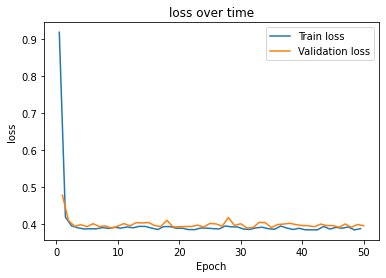

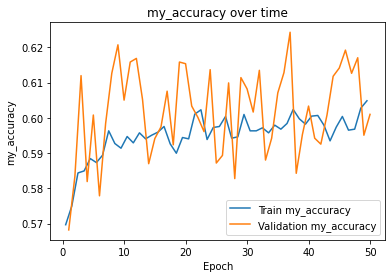

33/33 [==============================] - 0s 5ms/step - loss: 0.3606 - my_accuracy: 0.5912
Epoch 1/50
330/330 [==============================] - 5s 16ms/step - loss: 0.9360 - my_accuracy: 0.5645 - val_loss: 0.4783 - val_my_accuracy: 0.5689
Epoch 2/50
330/330 [==============================] - 5s 15ms/step - loss: 0.4174 - my_accuracy: 0.5843 - val_loss: 0.4017 - val_my_accuracy: 0.6042
Epoch 3/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3940 - my_accuracy: 0.5778 - val_loss: 0.3926 - val_my_accuracy: 0.6114
Epoch 4/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3884 - my_accuracy: 0.5816 - val_loss: 0.3944 - val_my_accuracy: 0.6099
Epoch 5/50
330/330 [==============================] - 5s 16ms/step - loss: 0.3866 - my_accuracy: 0.5862 - val_loss: 0.3929 - val_my_accuracy: 0.6075
Epoch 6/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3865 - my_accuracy: 0.5867 - val_loss: 0.3906 - val_my_accuracy: 0.6136
Epoch 7/50
330/3

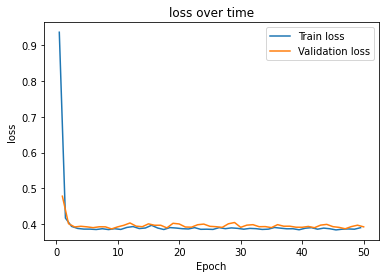

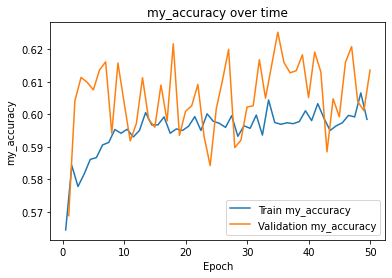

33/33 [==============================] - 0s 5ms/step - loss: 0.3612 - my_accuracy: 0.5758
Epoch 1/50
330/330 [==============================] - 6s 17ms/step - loss: 0.9394 - my_accuracy: 0.5647 - val_loss: 0.4824 - val_my_accuracy: 0.5902
Epoch 2/50
330/330 [==============================] - 4s 14ms/step - loss: 0.4218 - my_accuracy: 0.5759 - val_loss: 0.4026 - val_my_accuracy: 0.6050
Epoch 3/50
330/330 [==============================] - 4s 13ms/step - loss: 0.3943 - my_accuracy: 0.5835 - val_loss: 0.3945 - val_my_accuracy: 0.6067
Epoch 4/50
330/330 [==============================] - 5s 14ms/step - loss: 0.3876 - my_accuracy: 0.5884 - val_loss: 0.3926 - val_my_accuracy: 0.6016
Epoch 5/50
330/330 [==============================] - 4s 13ms/step - loss: 0.3862 - my_accuracy: 0.5891 - val_loss: 0.3934 - val_my_accuracy: 0.6023
Epoch 6/50
330/330 [==============================] - 4s 14ms/step - loss: 0.3856 - my_accuracy: 0.5881 - val_loss: 0.3886 - val_my_accuracy: 0.6116
Epoch 7/50
330/3

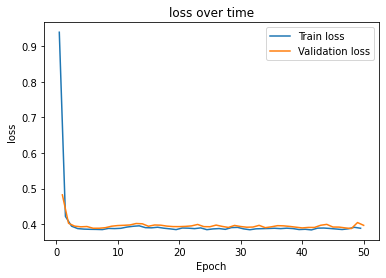

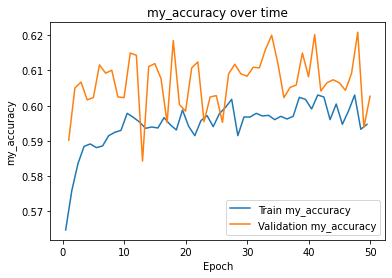

33/33 [==============================] - 0s 6ms/step - loss: 0.3625 - my_accuracy: 0.5783
Epoch 1/50
330/330 [==============================] - 5s 16ms/step - loss: 0.9108 - my_accuracy: 0.5616 - val_loss: 0.4618 - val_my_accuracy: 0.5999
Epoch 2/50
330/330 [==============================] - 5s 16ms/step - loss: 0.4138 - my_accuracy: 0.5777 - val_loss: 0.3969 - val_my_accuracy: 0.6192
Epoch 3/50
330/330 [==============================] - 5s 16ms/step - loss: 0.3913 - my_accuracy: 0.5873 - val_loss: 0.4019 - val_my_accuracy: 0.5678
Epoch 4/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3880 - my_accuracy: 0.5816 - val_loss: 0.3891 - val_my_accuracy: 0.6150
Epoch 5/50
330/330 [==============================] - 5s 14ms/step - loss: 0.3852 - my_accuracy: 0.5883 - val_loss: 0.3897 - val_my_accuracy: 0.6077
Epoch 6/50
330/330 [==============================] - 5s 14ms/step - loss: 0.3852 - my_accuracy: 0.5870 - val_loss: 0.3900 - val_my_accuracy: 0.6001
Epoch 7/50
330/3

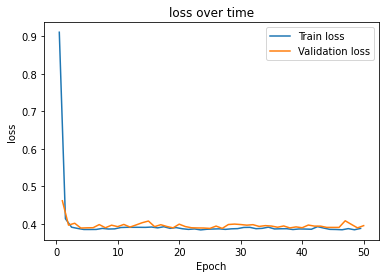

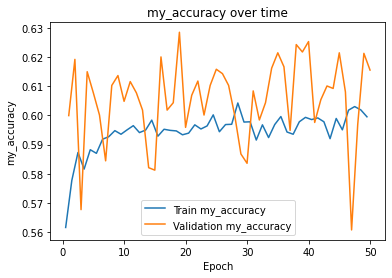

33/33 [==============================] - 0s 6ms/step - loss: 0.3633 - my_accuracy: 0.5795
Epoch 1/50
330/330 [==============================] - 5s 16ms/step - loss: 0.9550 - my_accuracy: 0.5631 - val_loss: 0.4937 - val_my_accuracy: 0.5701
Epoch 2/50
330/330 [==============================] - 5s 15ms/step - loss: 0.4251 - my_accuracy: 0.5794 - val_loss: 0.4116 - val_my_accuracy: 0.5779
Epoch 3/50
330/330 [==============================] - 5s 14ms/step - loss: 0.3949 - my_accuracy: 0.5788 - val_loss: 0.3987 - val_my_accuracy: 0.5938
Epoch 4/50
330/330 [==============================] - 5s 14ms/step - loss: 0.3888 - my_accuracy: 0.5848 - val_loss: 0.3939 - val_my_accuracy: 0.5966
Epoch 5/50
330/330 [==============================] - 5s 14ms/step - loss: 0.3856 - my_accuracy: 0.5935 - val_loss: 0.3965 - val_my_accuracy: 0.5929
Epoch 6/50
330/330 [==============================] - 5s 15ms/step - loss: 0.3850 - my_accuracy: 0.5885 - val_loss: 0.3872 - val_my_accuracy: 0.6107
Epoch 7/50
330/3

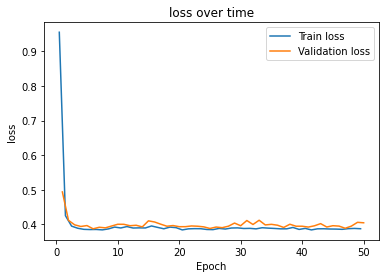

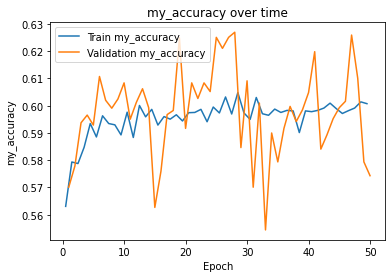

33/33 [==============================] - 0s 6ms/step - loss: 0.3682 - my_accuracy: 0.5720
0.5793560606060607 0.5912247474747475


In [ ]:
# Built the model

from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float64')


def plot_performance(history, metrics = ["loss", "my_accuracy"]):
  for metric in metrics:
    plt.plot([i-.5 for i in range(1,epochs+1)], history.history[metric], label="Train " + metric)
    plt.plot(range(1,epochs+1), history.history["val_" + metric], label="Validation " + metric)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(metric + " over time")
    plt.show()

def create_model():
  model = keras.Sequential()
  model.add(Dense(1024, name = "hidden_layer_1", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
    bias_regularizer=regularizers.l2(1e-3)))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.1))
  model.add(Dense(256, name = "hidden_layer_2", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
    bias_regularizer=regularizers.l2(1e-3)))
  model.add(LeakyReLU(0.3))
  model.add(Dropout(0.1))
  model.add(Dense(1, name = "output_layer"))
  # model.compile(optimizer = 'adam', 
  #               loss = keras.losses.BinaryCrossentropy(from_logits=True), 
  #               metrics =['accuracy'])
  model.compile(optimizer = 'adam', 
                loss = 'mean_absolute_error',
                metrics=[my_accuracy])
  return model

accuracy = []
for i in range(5):
  epochs= 50
  model = create_model()
  callbacks = [EarlyStopping(monitor='val_my_accuracy', patience=epochs),
          ModelCheckpoint(filepath='best_model.h5', monitor='val_my_accuracy', save_best_only=True)]
  history_model = model.fit(X, y, callbacks = callbacks, epochs=epochs, validation_split=0.1)

  plot_performance(history_model)
  accuracy.append(model.evaluate(X_test, y_test)[1])
  # for layer in model.layers: 
  #   print(layer.get_config(), layer.get_weights())
print(np.mean(accuracy), max(accuracy))

In [ ]:
# Accuracy method to calculate the percentage of correct prediction
def my_accuracy(y_pred, y_valid):
  count = 0
  for i in range(len(y_valid)):
    if (y_pred[i]/y_valid[i] > 0):
      count += 1
  return(count/len(y_valid))

In [ ]:
# results is a numpy array with the predicted class for each item in validation

results = model.predict(X_test)
error = []
for i in range(len(results)):
  if (results[i]/y_test.iloc[i]['result'] > 0):
    error.append(i)
X_test.iloc[error]

In [ ]:
# Transfer learning implement with low accuracy

false = 0
change = 0
result = model.predict(X_test)
for index, row in X_test_id.iterrows():
  if result[index]/y_test.iloc[index]['result'] < 0:
    false += 1
    model_team = model
    team = df.loc[df['match_id'] == row['match_id']].iloc[0][['team_1', 'team_2']]
    team_list = df.loc[(df['team_1'] == team['team_1']) | (df['team_1'] == team['team_2']) |
                      (df['team_2'] == team['team_1']) | (df['team_2'] == team['team_2'])]['match_id'].to_list()
    X_team = X_id.loc[X_id['match_id'].isin(team_list)].drop(columns='match_id')
    y_team = y_id.loc[y_id['match_id'].isin(team_list)].drop(columns='match_id')
    if len(X_team > 200):
      model_team.fit(X_team, y_team, epochs=1, batch_size=int(len(X_team)))
    if ((model_team.predict(X_test)[index])/(y_test.iloc[index]['result'])) > 0:
      change += 1
print(change/false, (len(X_test) - false + change)/len(X_test))
